# Clintox Plots

In [2]:
import os
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from datetime import datetime
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from typing import List, Iterator, Dict

In [4]:
from scope.compressors import get_compressor
from scope.matrix import MatrixFactory as MatrixFactory
from scope.samples.sample_generator import generate_samples

In [5]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
plt.rcParams['figure.max_open_warning'] = 0
plt.ioff()
np.random.seed(42)

In [6]:
FILE_NAME: str = 'clintox'
FILE_PATH: str = os.path.join('data', 'dataset', f'{FILE_NAME}.csv')
RESULTS_PATH: str = os.path.join('data', 'results', 'Images')
SMILES_COLUMN: str = 'smiles'
LABEL_COLUMN: str = 'CT_TOX'

In [7]:
STR_SEPARATOR: str = '\t'

MIN_SAMPLES: int = 50

COMPRESSION_DISTANCES_TO_EVALUATE: List[str] = [
    'ncd',
    'cdm',
    'clm',
    'mse'
]

COMPRESSORS_FUNCTIONS_TO_EVALUATE: List[str] = [
    'gzip',
    'bz2',
    'lz77',
    'zstandard'
]

BEST_SIGMA: List[bool] = [True, False]
USE_MATCHING_METHOD: List[bool] = [True, False]

In [8]:
def generate_combinations() -> Iterator[Dict]:
    """
    Generador que produce combinaciones una a la vez.
    Útil para datasets grandes donde no quieres cargar todas las combinaciones en memoria.
    
    Yields:
        Dict: Diccionario con una combinación de parámetros
    """
    for distance, compressor, best_sigma, use_matching in itertools.product(
        COMPRESSION_DISTANCES_TO_EVALUATE,
        COMPRESSORS_FUNCTIONS_TO_EVALUATE,
        BEST_SIGMA,
        USE_MATCHING_METHOD
    ):
        yield {
            'str_separator': STR_SEPARATOR,
            'min_samples': MIN_SAMPLES,
            'compression_distance': distance,
            'compressor': compressor,
            'best_sigma': best_sigma,
            'use_matching_method': use_matching
        }

In [9]:
dataframe: pd.DataFrame = pd.read_csv(FILE_PATH)
X: np.ndarray = dataframe[SMILES_COLUMN].values
Y: np.ndarray = dataframe[LABEL_COLUMN].values

In [10]:
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

if not os.path.exists(os.path.join(RESULTS_PATH, "compression_matrix")):
    os.makedirs(os.path.join(RESULTS_PATH, "compression_matrix"))

if not os.path.exists(os.path.join(RESULTS_PATH, "pca_2d")):
    os.makedirs(os.path.join(RESULTS_PATH, "pca_2d"))

if not os.path.exists(os.path.join(RESULTS_PATH, "pca_3d")):
    os.makedirs(os.path.join(RESULTS_PATH, "pca_3d"))

In [11]:
combinations_list = list(generate_combinations())

## Compression Matrix Plots

In [18]:
for combination in tqdm(combinations_list, desc="Generating Plots"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), dpi=300)
        
    compressor = get_compressor(name=combination['compressor'])
    name_distance_function = combination['compression_distance']
    str_separator = combination['str_separator']
    

    figname = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    matrix_test: MatrixFactory = MatrixFactory(
        compressor_module=compressor,
        name_distance_function=name_distance_function,
        str_separator=str_separator
    )
    
    for x_test, y_target_test, kw_samples_test in generate_samples(data=X, labels=Y, num_samples=combination['min_samples']):

        matrix_result_test: dict = matrix_test(x_test, kw_samples_test, get_best_sigma=combination['best_sigma'])
        
        fig.suptitle('ScOPE: Compression Matrix', 
                    fontsize=16, fontweight='bold', y=0.95)
        
        for index, key in enumerate(matrix_result_test):
            if index == 2:
                break
            ax = axes[index]

            if 'ScOPEC_' in key:
                class_name = key.replace('ScOPEC_', '')

                ax.text(0.5, -0.1, 'Reference Samples (Known Property)', 
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=13, style='italic', color='darkgreen',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.3))
                
                img = ax.imshow(matrix_result_test[key], cmap="plasma", aspect='auto')
                
            elif 'ScOPES_' in key:
                # Add text annotation
                ax.text(0.5, -10, 'Query Sample (Unknown Property)', 
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=13, style='italic', color='darkred',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.3))
                
                img = ax.imshow(matrix_result_test[key], cmap="plasma")

            ax.set_yticks([])
            ax.set_yticklabels([])
            ax.set_xticks([])
            ax.set_xticklabels([])
            
            for spine in ax.spines.values():
                spine.set_linewidth(2)
                if 'ScOPEC_' in key:
                    spine.set_color('darkgreen')
                else:
                    spine.set_color('darkred')

        # Add colorbar
        cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
        cbar = fig.colorbar(img, cax=cbar_ax)
        cbar.set_label('Compression Distance\n(Information Content Shared)', 
                      rotation=90, fontsize=13, labelpad=15)
        
        method_info = (
            f"Samples: {combination['min_samples']} | "
            f"Method: {combination['compressor'].title()} | "
            f"Distance: {combination['compression_distance'].upper()} | "
            f"Separator: {repr(str_separator)} | "
            f"Best Sigma: {combination['best_sigma']} | "
            f"Matching: {combination['use_matching_method']}")
        
        fig.text(0.5, -0.05, method_info, ha='center', va='bottom',
                fontsize=10, style='italic', color='gray',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.5))
        
        # Adjust layout
        plt.subplots_adjust(left=0.08, right=0.90, top=0.85, bottom=0.15, wspace=0.25)
        
        plt.savefig(
            os.path.join(RESULTS_PATH, "compression_matrix" ,f"{figname}.png"),
            dpi=300,
            bbox_inches='tight'
        )
        
        plt.close(fig)
        break

Generating Plots:   0%|          | 0/64 [00:00<?, ?it/s]

## PCA 2D Plots

In [16]:
pca = PCA(n_components=2, whiten=True)

for combination in tqdm(combinations_list, desc="Generating Plots"):
    plt.figure(figsize=(14, 8), dpi=300)
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#8E44AD', '#27AE60']
        
    compressor = get_compressor(name=combination['compressor'])
    name_distance_function = combination['compression_distance']
    str_separator = combination['str_separator']

    figname = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    matrix_test: MatrixFactory = MatrixFactory(
        compressor_module=compressor,
        name_distance_function=name_distance_function,
        str_separator=str_separator
    )
    
    for x_test, y_target_test, kw_samples_test in generate_samples(data=X, labels=Y, num_samples=combination['min_samples']):

        matrix_result_test: dict = matrix_test(x_test, kw_samples_test, get_best_sigma=combination['best_sigma'])
        
        grouped_classes = {}
        
        for class_name, values in matrix_result_test.items():
            suffix = class_name.find('class_')
            if suffix == -1:
                continue
            
            class_suffix = class_name[suffix:]
            if class_suffix not in grouped_classes:
                grouped_classes[class_suffix] = []

            grouped_classes[class_suffix].extend(values)
            
        pca_results = {}
        
        for class_name, arrays in grouped_classes.items():
            data_matrix = np.vstack(arrays)
            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(data_matrix)
            pca_results[class_name] = pca_result
        
        for idx, (class_name, pca_transformed) in enumerate(pca_results.items()):
            plt.scatter(
                pca_transformed[:-1, 0],
                pca_transformed[:-1, 1],
                label=f'{class_name.replace("_", " ").title()} (Reference)',
                alpha=0.7,
                s=80,  # Puntos más grandes
                color=colors[idx % len(colors)],
                edgecolors='white',
                linewidth=0.8
            )
        
        sample_pca_class_1 = pca_results['class_0'][-1, :]
        sample_pca_class_2 = pca_results['class_1'][-1, :]

        plt.scatter(
            sample_pca_class_1[0],
            sample_pca_class_1[1],
            label="Sample based on class 0",
            color=colors[0],
            marker='X',
            s=200,
            alpha=1,
            edgecolors='black',
            linewidth=2
        )
        plt.scatter(
            sample_pca_class_2[0],
            sample_pca_class_2[1],
            label="Sample based on class 1",
            color=colors[1],
            marker='X',
            s=200,
            alpha=1,
            edgecolors='black',
            linewidth=2
        )

        plt.title(f"ScOPE PCA Visualization\nQuery Sample Classification (True Class: {y_target_test})", 
                 fontsize=14, fontweight='bold', pad=20)
        
        plt.xlabel("Principal Component 1", fontsize=14)
        plt.ylabel("Principal Component 2", fontsize=14)
        
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), 
                  frameon=True, fancybox=True, shadow=True, fontsize=11)
        
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.gca().set_facecolor('#fafafa')
        
        method_info = (
            f"Samples: {combination['min_samples']} | "
            f"Method: {combination['compressor'].title()} | "
            f"Distance: {combination['compression_distance'].upper()} | "
            f"Separator: {repr(str_separator)} | "
            f"Best Sigma: {combination['best_sigma']} | "
            f"Matching: {combination['use_matching_method']}"
        )
        
        plt.figtext(0.5, 0.02, method_info, ha='center', va='bottom',
                   fontsize=10, style='italic', color='gray',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.7))
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        
        plt.savefig(
            os.path.join(RESULTS_PATH, "pca_2d" ,f"{figname}.png"),
            dpi=300,
            bbox_inches='tight'
        )
        plt.close()
        
        break
    

Generating Plots:   0%|          | 0/64 [00:00<?, ?it/s]

## PCA 3D Plots

Generating Plots:   0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 

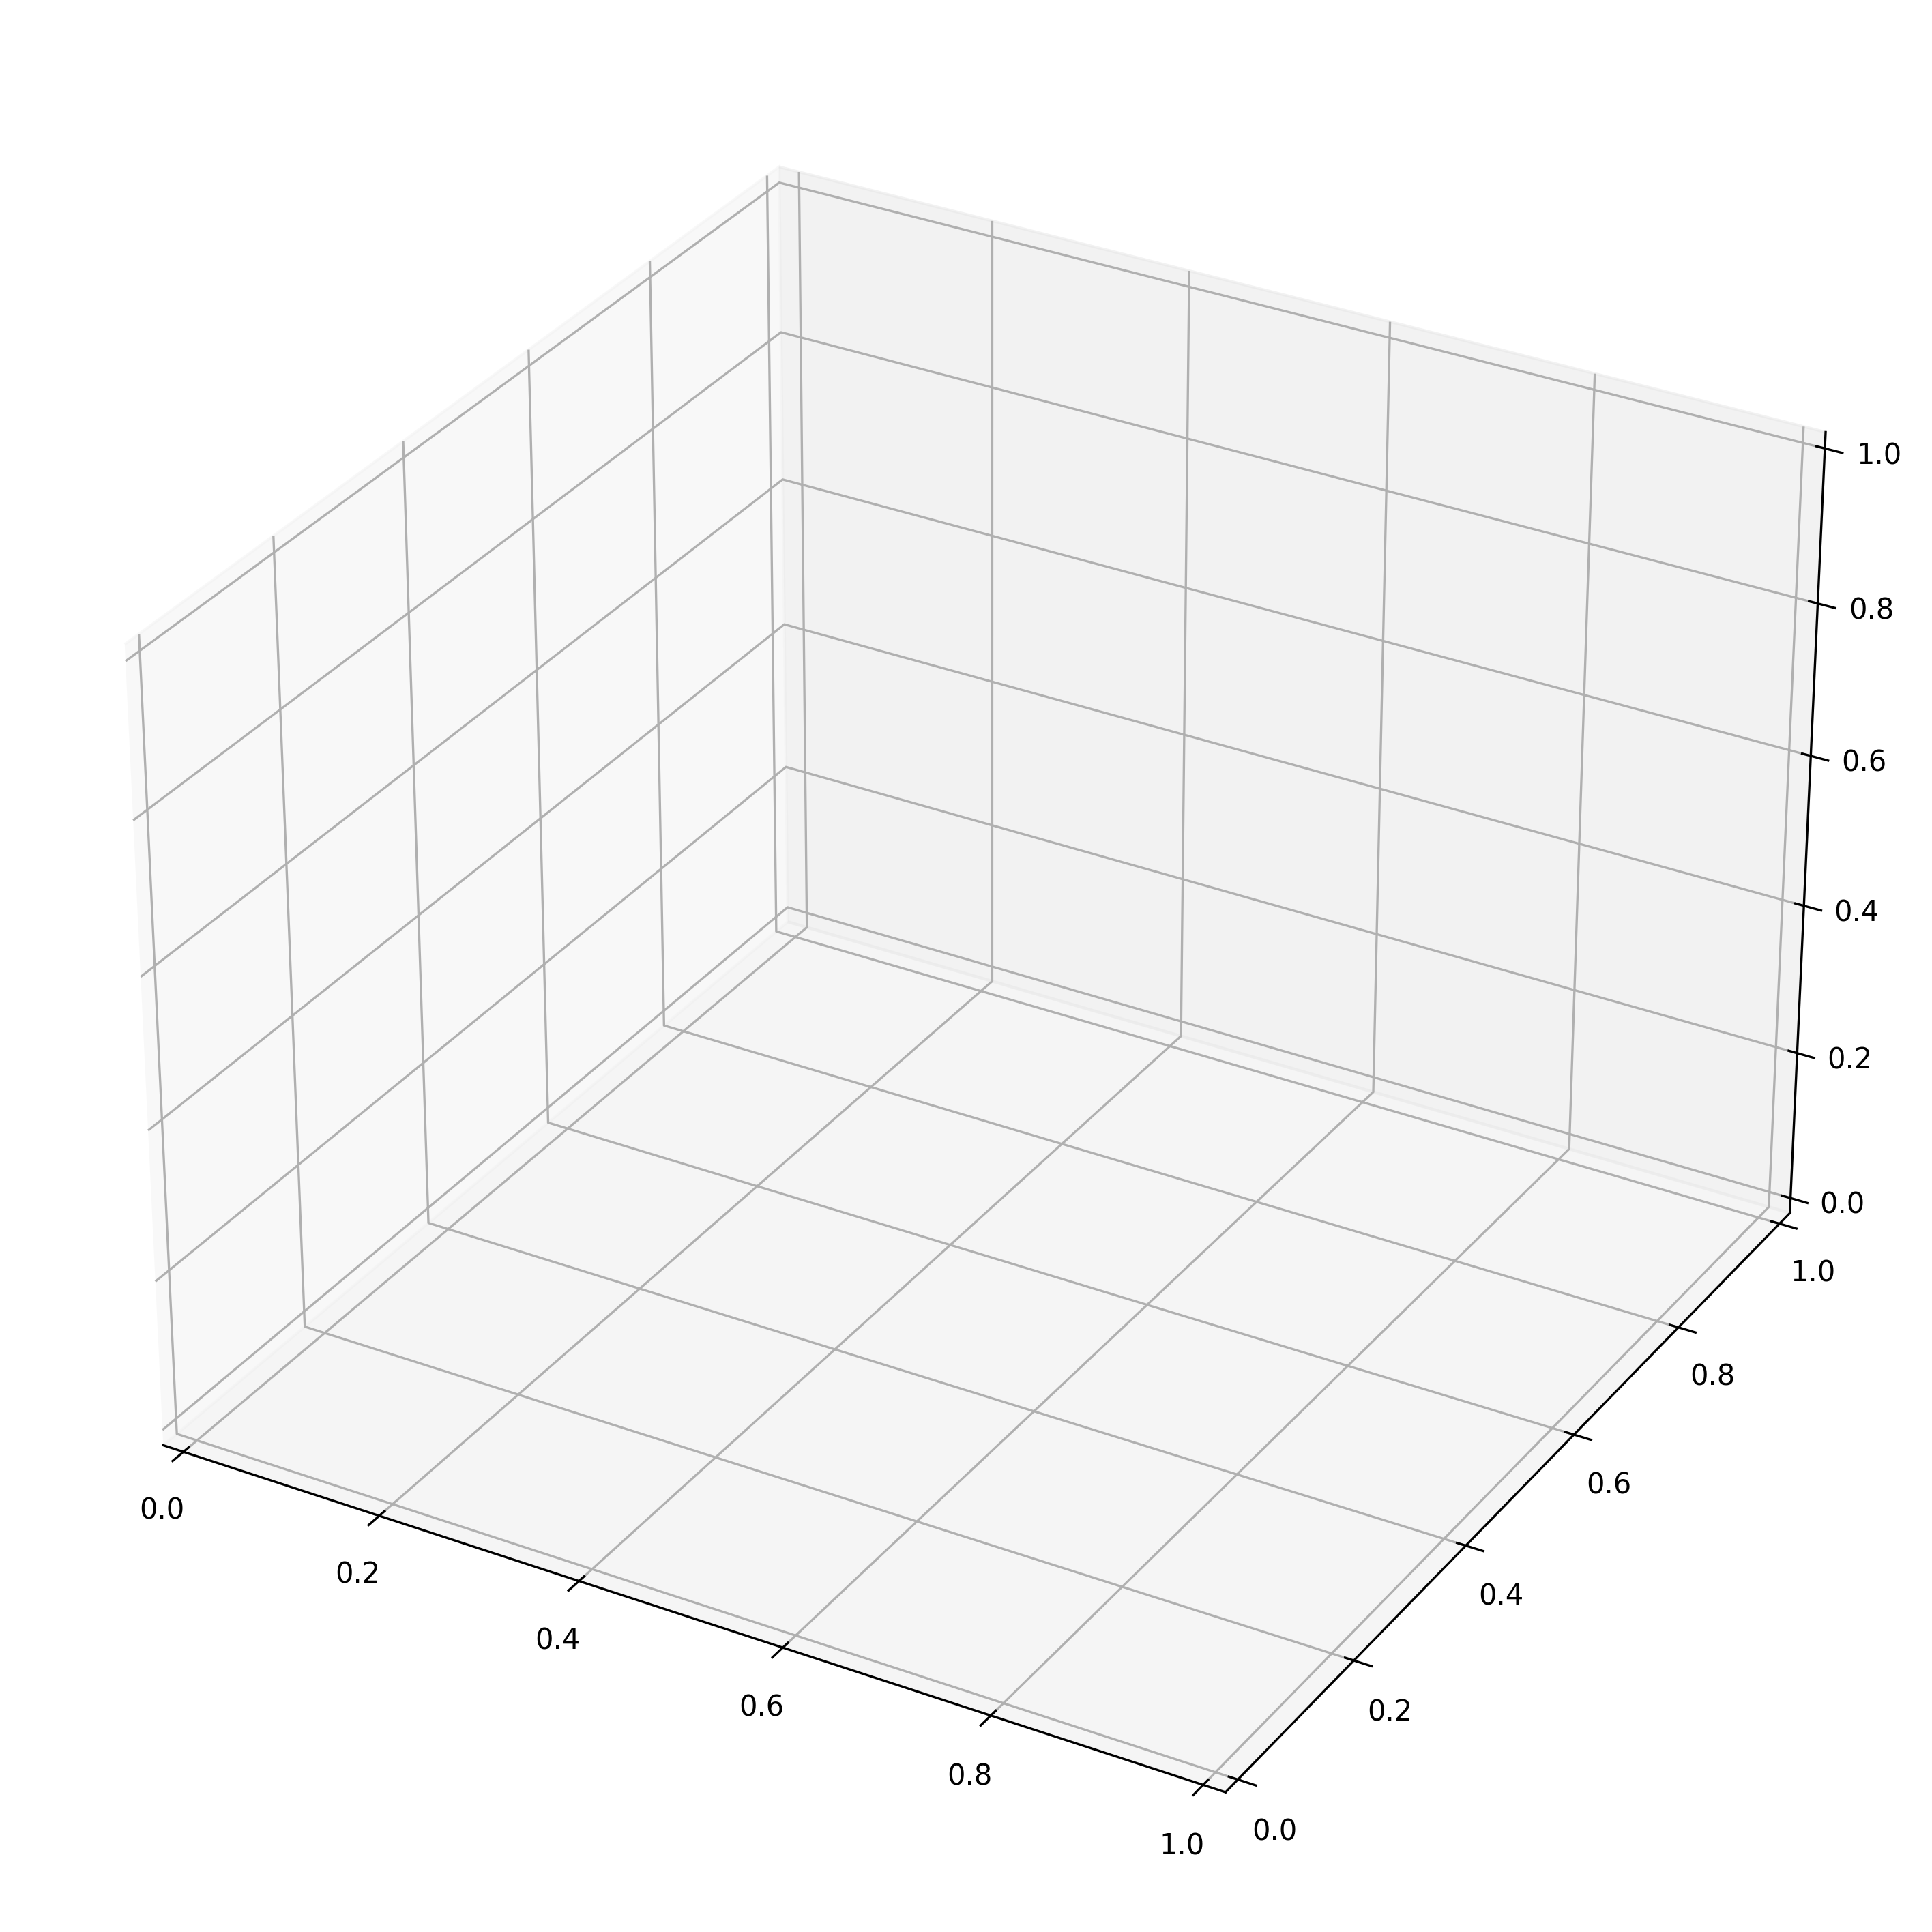

In [31]:
pca = PCA(n_components=3, whiten=True)

for combination in tqdm(combinations_list, desc="Generating Plots"):
    fig = plt.figure(figsize=(16, 12), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#8E44AD', '#27AE60']
        
    compressor = get_compressor(name=combination['compressor'])
    name_distance_function = combination['compression_distance']
    str_separator = combination['str_separator']

    figname = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    matrix_test: MatrixFactory = MatrixFactory(
        compressor_module=compressor,
        name_distance_function=name_distance_function,
        str_separator=str_separator
    )
    
    for x_test, y_target_test, kw_samples_test in generate_samples(data=X, labels=Y, num_samples=combination['min_samples']):

        matrix_result_test: dict = matrix_test(x_test, kw_samples_test, get_best_sigma=combination['best_sigma'])
        
        grouped_classes = {}
        
        for class_name, values in matrix_result_test.items():
            suffix = class_name.find('class_')
            if suffix == -1:
                continue
            
            class_suffix = class_name[suffix:]
            if class_suffix not in grouped_classes:
                grouped_classes[class_suffix] = []

            grouped_classes[class_suffix].extend(values)
            
        pca_results = {}
        
        for class_name, arrays in grouped_classes.items():
            data_matrix = np.vstack(arrays)
            pca_result = pca.fit_transform(data_matrix)
            pca_results[class_name] = pca_result
        
        for idx, (class_name, pca_transformed) in enumerate(pca_results.items()):
            ax.scatter(
                pca_transformed[:-1, 0],
                pca_transformed[:-1, 1],
                pca_transformed[:-1, 2],
                label=f'{class_name.replace("_", " ").title()} (Reference)',
                alpha=0.7,
                s=80,
                color=colors[idx % len(colors)],
                edgecolors='white',
                linewidth=0.8
            )
        
        sample_pca_class_1 = pca_results['class_0'][-1, :]
        sample_pca_class_2 = pca_results['class_1'][-1, :]

        ax.scatter(
            sample_pca_class_1[0],
            sample_pca_class_1[1],
            sample_pca_class_1[2],
            label="Sample based on class 0",
            color=colors[0],
            marker='X',
            s=200,
            alpha=1,
            edgecolors='black',
            linewidth=2
        )
        ax.scatter(
            sample_pca_class_2[0],
            sample_pca_class_2[1],
            sample_pca_class_2[2],
            label="Sample based on class 1",
            color=colors[1],
            marker='X',
            s=200,
            alpha=1,
            edgecolors='black',
            linewidth=2
        )

        ax.set_title(f"ScOPE PCA Visualization\nQuery Sample Classification (True Class: {y_target_test})", 
                    fontsize=14, fontweight='bold', pad=20)
        
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.set_zlabel("Principal Component 3")
        
        ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), 
                 frameon=True, fancybox=True, shadow=True, fontsize=11)
        
        ax.grid(True, alpha=0.3)
        
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        
        ax.xaxis.pane.set_edgecolor('gray')
        ax.yaxis.pane.set_edgecolor('gray')
        ax.zaxis.pane.set_edgecolor('gray')
        ax.xaxis.pane.set_alpha(0.1)
        ax.yaxis.pane.set_alpha(0.1)
        ax.zaxis.pane.set_alpha(0.1)
        
        method_info = (
            f"Samples: {combination['min_samples']} | "
            f"Method: {combination['compressor'].title()} | "
            f"Distance: {combination['compression_distance'].upper()} | "
            f"Separator: {repr(str_separator)} | "
            f"Best Sigma: {combination['best_sigma']} | "
            f"Matching: {combination['use_matching_method']}"
        )
        
        plt.figtext(0.5, 0.02, method_info, ha='center', va='bottom',
                   fontsize=10, style='italic', color='gray',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.7))
        
        ax.view_init(elev=20, azim=45)
        
        plt.tight_layout()
        
        plt.savefig(
            os.path.join(RESULTS_PATH, "pca_3d", f"{figname}.png"),
            dpi=300,
            bbox_inches='tight'
        )
                
        plt.close(fig)
        break
